# Identify the best Model for out project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import lightgbm as lgb

import category_encoders as ce
from imblearn.over_sampling import SMOTE,SMOTENC
from imblearn.under_sampling import RandomUnderSampler
import statsmodels.api as sm
from xgboost import XGBClassifier
import sklearn
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, fbeta_score, r2_score, mean_squared_error, accuracy_score, log_loss,\
                            ConfusionMatrixDisplay, roc_auc_score, classification_report, confusion_matrix, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, f1_score, precision_recall_curve,\
                            roc_curve
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, LogisticRegression, LogisticRegressionCV, LinearRegression 
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import pickle
import warnings
warnings.filterwarnings('ignore')

C:\Users\karla\anaconda3\envs\practica_0\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def evaluate_model(yval, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(yval, ypred_proba[:, 1])))
        print(f'\nF2 Score: {fbeta_score(yval, ypred, beta=2, average="macro")}\n')
        print(f'R2 Score: {r2_score(yval, ypred)}\n')
        print('Accuracy of the model: {}\n'.format(accuracy_score(yval, ypred)))
        print('Classification report: \n{}\n'.format(classification_report(yval, ypred)))

In [3]:
def cargar_modelo(ruta):
    return pickle.load(open(ruta, 'rb'))

In [4]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [5]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

# Transformacion de variables y pasos previos a los modelos.

In [6]:
# Lecutra de datos preprocesados
df = pd.read_parquet('C:/Users/karla/Documents/CUNEF/5_machine_learning/2_practicas/Fraude/data/process/pd_datafruad_preprocessing.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 15 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   step              1048575 non-null  float64 
 1   type              1048575 non-null  category
 2   amount            1048575 non-null  float64 
 3   gender            1048575 non-null  object  
 4   device            1048575 non-null  object  
 5   connection_time   1048575 non-null  float64 
 6   oldbalanceOrg     1048575 non-null  float64 
 7   newbalanceOrig    1048575 non-null  float64 
 8   zone              1048575 non-null  object  
 9   user_number       1048575 non-null  float64 
 10  user_connections  1048575 non-null  float64 
 11  security_alert    1048575 non-null  float64 
 12  oldbalanceDest    1048575 non-null  float64 
 13  newbalanceDest    1048575 non-null  float64 
 14  isFraud           1048575 non-null  float64 
dtypes: category(1), float64(11), obj

- Creacion del pipeline para aplicarlo posteriormente a los modelos

In [7]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [8]:
numeric = df.select_dtypes(include=['int64', 'float64']).drop(['isFraud'], axis=1).columns

categorical = df.select_dtypes(include=['object']).columns

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric),
        ('cat', categorical_transformer, categorical)])

In [10]:
# Guardamos el preprocessor
with open('../modelos/preprocessor.pickle', 'wb') as f:
    pickle.dump(preprocessor, f)

In [11]:
X = df.drop('isFraud', axis= 1)
y = df.isFraud

In [12]:
xtrain, xval, ytrain, yval = train_test_split(X, y, stratify = y, test_size=0.25,  random_state=0)
xtrain, xtest, ytrain, ytest = train_test_split(xtrain, ytrain, stratify = ytrain, test_size=0.25,  random_state=0)

In [13]:
list_columns_cat = list(xtrain.select_dtypes('category').columns)
list_columns_cat
list_columns_num = list(xtrain.select_dtypes('float64').columns)
list_columns_num

['step',
 'amount',
 'connection_time',
 'oldbalanceOrg',
 'newbalanceOrig',
 'user_number',
 'user_connections',
 'security_alert',
 'oldbalanceDest',
 'newbalanceDest']

# Data Balance / Balanceo de Datos

Para tratar el dessbalanceo  vamos a hacer primero una reduccion de datos de la clase mayoritaria y luego un incremento de las clases minoritarias

In [14]:
# Confirmamos la distribucion  de los datos de nuestra variable objetivo antes del balanceo
ytrain.value_counts()

0.0    589181
1.0       642
Name: isFraud, dtype: int64

### 1. Downsampling

**1.1 We make the downsampling of the majority class**

In [15]:
rus=RandomUnderSampler(random_state=0)
xtrain_und,ytrain_und=rus.fit_resample(xtrain, ytrain)
ytrain_und.value_counts()

0.0    642
1.0    642
Name: isFraud, dtype: int64

**1.2 We create a dummy model to identify verify the ooutput of the model in the downsampling**

In [16]:
# Create the model
base_model = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('clasificador', DummyClassifier(strategy='most_frequent', random_state=0))])

# Train our model
base_model.fit(xtrain_und, ytrain_und)

# Predict values
ypred = base_model.predict(xval)
ypred_proba = base_model.predict_proba(xval)
evaluate_model(yval,ypred,ypred_proba)

ROC-AUC score of the model: 0.5

F2 Score: 0.49989080435194294

R2 Score: -0.0010921950064539665

Accuracy of the model: 0.9989089965820312

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    261858
         1.0       0.00      0.00      0.00       286

    accuracy                           1.00    262144
   macro avg       0.50      0.50      0.50    262144
weighted avg       1.00      1.00      1.00    262144




### 2. Downsampling and upsampling combined

**2.1 With the dataset still unbalance (but reduce) we are going to make a SMOTE method to balance both columns**

In [17]:
xtrain.head()

,step,type,amount,gender,device,connection_time,oldbalanceOrg,newbalanceOrig,zone,user_number,user_connections,security_alert,oldbalanceDest,newbalanceDest
942625,43.0,CASH_OUT,354411.18,woman,pc,0.829600,0.00,0.00,country,3819.0,9.0,0.0,3190630.47,3533676.02
252984,14.0,CASH_OUT,155793.09,woman,iphone,0.030974,0.00,0.00,missing,3133.0,8.0,1.0,168510.52,480830.60
371255,17.0,CASH_IN,314572.95,unknow,mac,0.470033,4122284.74,4436857.70,africa,3361.0,4.0,0.0,3073422.19,2540851.38
550135,21.0,CASH_IN,7487.94,unknow,pc,0.895300,3956102.27,3963590.21,africa,3333.0,2.0,0.0,356582.62,349094.68
476228,19.0,CASH_OUT,104592.45,man,pc,0.867231,31638.00,0.00,missing,2285.0,9.0,0.0,0.00,104592.45


In [18]:
# Concatemnamos el xtrain y el ytrain
df_fraud_unsample = xtrain.join(ytrain)
df_fraud_unsample

# Dividimos los casos que fueron fraude de los que no fueron fraude
df_major = df_fraud_unsample[df_fraud_unsample.isFraud == 0]
df_minor = df_fraud_unsample[df_fraud_unsample.isFraud == 1]

# Reducimos la contidad de filas de el dataframe mayoritario a la mitad
df_majority_downsample = resample(df_major, replace = False, n_samples = 
                                  146281, random_state = 12345)

# Concatenamos el dataset majoritario reducido con el dataset minoritario
df_majority_downsample = pd.concat([df_minor, df_majority_downsample])

# Divide the xtrain of the ytrain
xtrain= df_majority_downsample.drop('isFraud', axis = 1)
ytrain = df_majority_downsample.isFraud

# We create the balance function
over = SMOTENC([1,3,4,8], random_state=0)

# We split the dataset
xtrain_over = df_majority_downsample.drop('isFraud', axis = 1)
ytrain_over = df_majority_downsample.isFraud

# # We apply the SMOTE to the actual dataset to increase the instances of the minority class
xtrain_over, ytrain_over = over.fit_resample(xtrain, ytrain)

In [19]:
# Verificamos que el balanceo se realizo de manera correcta
ytrain_over.value_counts()

1.0    146281
0.0    146281
Name: isFraud, dtype: int64

**2.2 We create a dummy model to identify verify the ooutput of the model in the combine downsampling and upsampling**

In [20]:
# Create the model
base_model = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('clasificador', DummyClassifier(strategy='most_frequent', random_state=0))])

# Train our model
base_model.fit(xtrain, ytrain)

# Predict values
ypred = base_model.predict(xval)
ypred_proba = base_model.predict_proba(xval)
evaluate_model(yval,ypred,ypred_proba)

ROC-AUC score of the model: 0.5

F2 Score: 0.49989080435194294

R2 Score: -0.0010921950064539665

Accuracy of the model: 0.9989089965820312

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    261858
         1.0       0.00      0.00      0.00       286

    accuracy                           1.00    262144
   macro avg       0.50      0.50      0.50    262144
weighted avg       1.00      1.00      1.00    262144




**CONCLUSION**

Using only downsampling and the combine up and downsampling, we can see that both datasets have the same output in regards of the recall and the precision when using our base model. Therefore we are going to only the downsampling dataset because as the data to handle is less, our process is going to take the shortest amount of time and as it was shown in the comparison, we are going to hade the same output.

In [21]:
xtrain=xtrain_und
ytrain=ytrain_und

ytrain.shape

(1284,)

- Save the data

In [22]:
xtrain.to_parquet("../data/xtrain.parquet")
xval.to_parquet("../data/xval.parquet")
pd.DataFrame(ytrain).to_parquet("../data/ytrain.parquet")
pd.DataFrame(yval).to_parquet("../data/yval.parquet")
pd.DataFrame(ytest).to_parquet("../data/ytest.parquet")
xtest.to_parquet("../data/xtest.parquet")

- Import and reading of the data previous to the modeling

In [23]:
xtrain = pd.read_parquet("../data/xtrain.parquet")
ytrain = pd.read_parquet("../data/ytrain.parquet")['isFraud']
xval = pd.read_parquet("../data/xtest.parquet")
yval = pd.read_parquet("../data/ytest.parquet")['isFraud']

# Objectives to Model / Objetivos del Modelado

- Because we are trying to identify the fraudulent cases within different transactions, we are going to use the evaluation metric of recall to compare each model. We are using this kind of metric because what we want as objetcive is to identify the maximun amount of cases where a transaction was fraudulent. Becauase this metric is good determinating how well the model is classifing the true possitives, this is the metric that will be taken into consideration during our process. Also we are going to try to look for a model with a good precision, but this will not have the same importance than the recall scoring.

- Also we are going to present the information of the ROC-AUC but as the main target of the project is to identify and correctly label only the true possitives and because of the ROC-AUC is good working both with identify possitive and negative classes, we are not going to give this metric importance in the moment of comparing the outputs of our models.

# Modeling / Modelado

We  will highlight the following information for that is going to be taken into consideration during the performance of the different models:
1. We are going to evaluate the recall and precision on each to evaluate its behaviour.
2. Eventhough we are going to show the ROC-AUC, we are going to take into conisderation the R2 and F2 score resultes to indetify how good our models are, this is because for this particular cases the ROC-AUC is not a good indicator of the models prediction capabilities.

### Modelo Base

In [24]:
base_model = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('clasificador', DummyClassifier(strategy='most_frequent', random_state=0))])

In [25]:
base_model.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['step', 'amount', 'connection_time', 'oldbalanceOrg', 'newbalanceOrig',
       'user_number', 'user_connections', 'security_alert', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'device', 'zone'], dtype='object'))])),
                ('clasificador',
                 DummyClassifier(random_state=0, strategy='most_frequent'))])

In [26]:
with open('../modelos/base_model.pickle', 'wb') as f:
    pickle.dump(base_model, f)

In [27]:
cargar_modelo('../modelos/base_model.pickle')

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['step', 'amount', 'connection_time', 'oldbalanceOrg', 'newbalanceOrig',
       'user_number', 'user_connections', 'security_alert', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'device', 'zone'], dtype='object'))])),
                ('clasificador',
                 DummyClassifier(random_state=0, strategy='most_frequent'))])

In [28]:
ypred = base_model.predict(xval)
ypred_proba = base_model.predict_proba(xval)
evaluate_model(yval,ypred,ypred_proba)

ROC-AUC score of the model: 0.5

F2 Score: 0.49989105910908754

R2 Score: -0.001089646323207294

Accuracy of the model: 0.9989115397135416

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    196394
         1.0       0.00      0.00      0.00       214

    accuracy                           1.00    196608
   macro avg       0.50      0.50      0.50    196608
weighted avg       1.00      1.00      1.00    196608




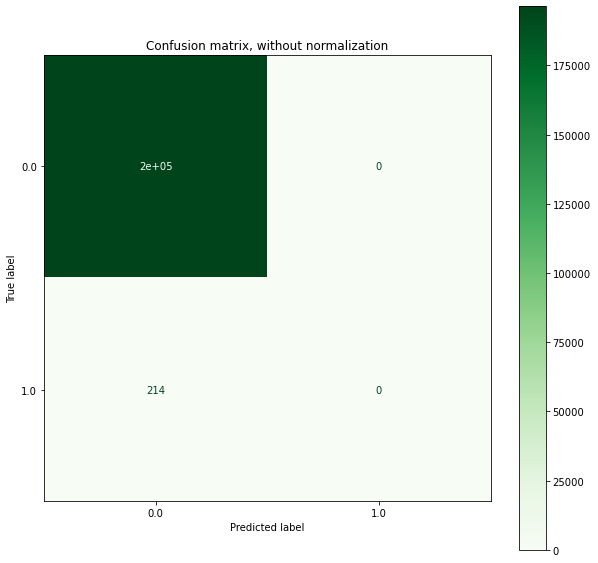

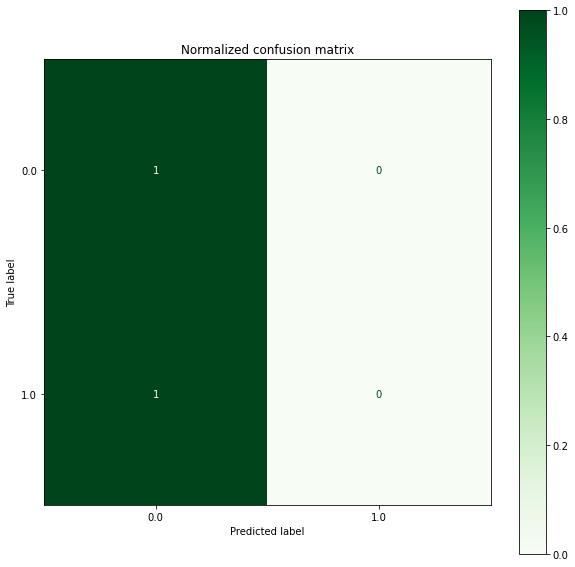

In [29]:
 titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
        fig, ax = plt.subplots(figsize=(10, 10))
        disp = ConfusionMatrixDisplay.from_predictions(yval, ypred,
                                                       cmap=plt.cm.Greens,
                                                       normalize=normalize,
                                                       ax=ax)
        ax.set_title(title)

**Conclusions**
- Using the base model (dummy classifier) the result of the score F2 is 49.98% and the AUC are both 50% wich means that the models is randomly predicting the outputs. This 49.98% is the bottom acceptance score for all coming models performance. 
- With this model, the output is that in the recall and presicion are both 0%. This means that the model is not able to identify any of the fraud transactions. 

This is not a good model to put into production, but as a base model, the output of this model will be compared to the output of other models.

### Regresión Logística (Ridge)

In [30]:
clf = Pipeline(steps=[
    ('preprocesador', preprocessor), 
    ('clasificador', LogisticRegressionCV(penalty='l2', random_state=0))])

In [31]:
clf.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['step', 'amount', 'connection_time', 'oldbalanceOrg', 'newbalanceOrig',
       'user_number', 'user_connections', 'security_alert', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'device', 'zone'], dtype='object'))])),
                ('clasificador', LogisticRegressionCV(random_state=0))])

In [32]:
# Guardamos en un pickle el modelo 
with open('../modelos/LR.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [33]:
cargar_modelo('../modelos/LR.pickle')

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['step', 'amount', 'connection_time', 'oldbalanceOrg', 'newbalanceOrig',
       'user_number', 'user_connections', 'security_alert', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'device', 'zone'], dtype='object'))])),
                ('clasificador', LogisticRegressionCV(random_state=0))])

In [34]:
ypred = clf.predict(xval)
ypred_proba = clf.predict_proba(xval)
evaluate_model(yval,ypred, ypred_proba)

ROC-AUC score of the model: 0.964640362940071

F2 Score: 0.5127511158060772

R2 Score: -52.960603132421475

Accuracy of the model: 0.9413299560546875

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97    196394
         1.0       0.02      0.86      0.03       214

    accuracy                           0.94    196608
   macro avg       0.51      0.90      0.50    196608
weighted avg       1.00      0.94      0.97    196608




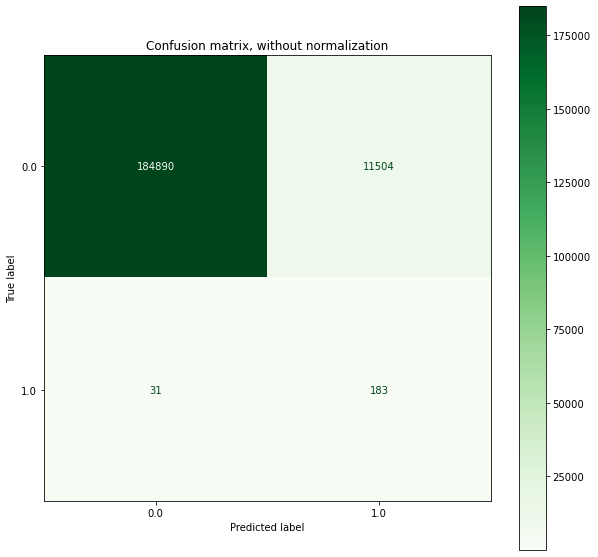

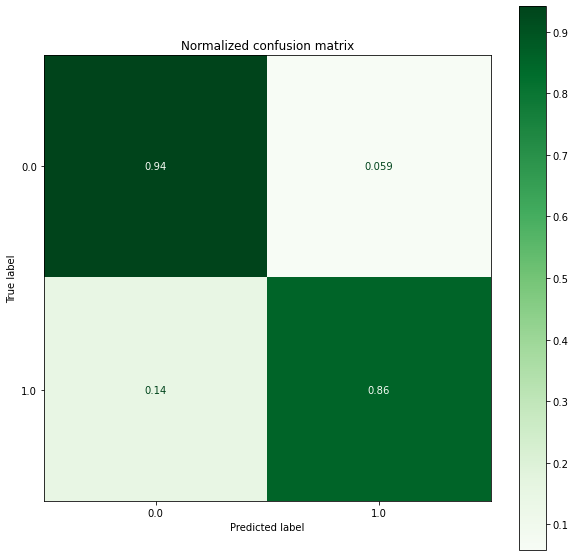

In [35]:
 titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
        fig, ax = plt.subplots(figsize=(10, 10))
        disp = ConfusionMatrixDisplay.from_predictions(yval, ypred,
                                                       cmap=plt.cm.Greens,
                                                       normalize=normalize,
                                                       ax=ax)
        ax.set_title(title)

**Conclusions**
- Using the base model (Linear Regression/ Ridge) the result of the score F2 is 52.3% wich means that the models is nearly randomly predicting the outputs. Even though the F2 score is almost randomly, the results are a little bit better than using the dummy model at the beggining. 
- With this model, the output is that in recall only 86% of all the fraud cases were detected, and the remaining 14% were classified as "not fraud" beign fraud. The precision of this model is very low (2%) because it classify many of the transactions as fraud, when these were actually not fraud. 

This is a better model than our base model for prediction, but regardless this is not a good model to put into production as the predictions are going to be made almost at randeom and we would be classifying a lot of cases like fraud not actually being fraud.

### Regresión Logística (Lasso)

In [36]:
clf = Pipeline(steps=[
    ('preprocesador', preprocessor), 
    ('clasificador', LogisticRegression(random_state=0, penalty='l1', solver='liblinear',verbose=10))])

In [37]:
clf.fit(xtrain, ytrain)

[LibLinear]

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['step', 'amount', 'connection_time', 'oldbalanceOrg', 'newbalanceOrig',
       'user_number', 'user_connections', 'security_alert', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'device', 'zone'], dtype='object'))])),
                ('clasificador',
                 LogisticRegression(penalty='l1', random_state=0,
                                    solver='liblinear', verbose=10))])

In [38]:
with open('../modelos/LRlasso.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [39]:
cargar_modelo('../modelos/LRlasso.pickle')

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['step', 'amount', 'connection_time', 'oldbalanceOrg', 'newbalanceOrig',
       'user_number', 'user_connections', 'security_alert', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'device', 'zone'], dtype='object'))])),
                ('clasificador',
                 LogisticRegression(penalty='l1', random_state=0,
                                    solver='liblinear', verbose=10))])

In [40]:
ypred = clf.predict(xval)
ypred_proba = clf.predict_proba(xval)
evaluate_model(yval, ypred, ypred_proba)

ROC-AUC score of the model: 0.9446615229599016

F2 Score: 0.526383885620918

R2 Score: -41.045765145574705

Accuracy of the model: 0.95428466796875

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98    196394
         1.0       0.02      0.84      0.04       214

    accuracy                           0.95    196608
   macro avg       0.51      0.90      0.51    196608
weighted avg       1.00      0.95      0.98    196608




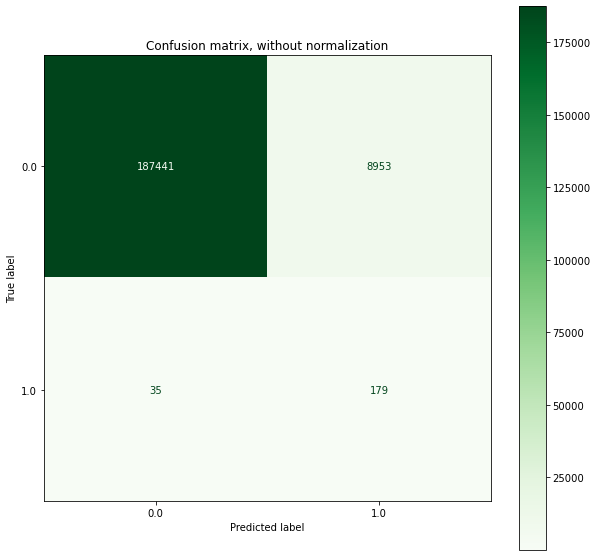

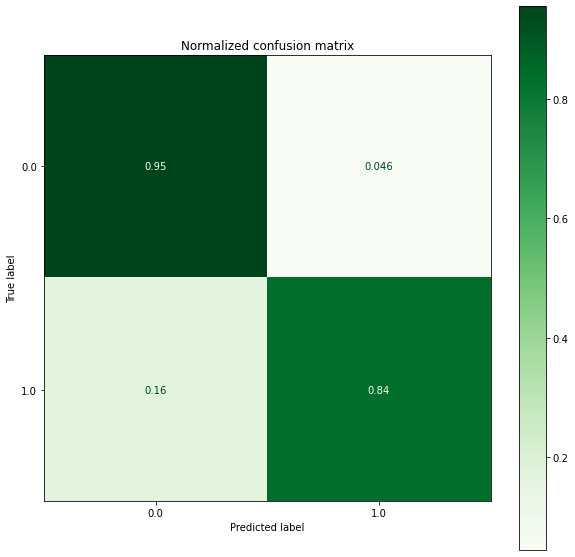

In [41]:
 titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
        fig, ax = plt.subplots(figsize=(10, 10))
        disp = ConfusionMatrixDisplay.from_predictions(yval, ypred,
                                                       cmap=plt.cm.Greens,
                                                       normalize=normalize,
                                                       ax=ax)
        ax.set_title(title)

**Conclusions**
- Using a model of Logistic regression (Lasso)the results are the same than doing the model of Linear Regression (Ridge). The result of the score F2 is 52.3% wich means that the models is nearly randomly predicting the outputs.And the recall only 81%  and the precision of this model in 2%

This is also better model than our base model for prediction, but regardless this is not a good model to put into production.

### Generalized Linear Models

In [42]:
clf = Pipeline(steps=[
    ('preprocesador', preprocessor), 
    ('clasificador', LinearRegression())])

In [43]:
clf.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['step', 'amount', 'connection_time', 'oldbalanceOrg', 'newbalanceOrig',
       'user_number', 'user_connections', 'security_alert', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'device', 'zone'], dtype='object'))])),
                ('clasificador', LinearRegression())])

In [44]:
with open('../modelos/GLM.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [45]:
cargar_modelo('../modelos/GLM.pickle')

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['step', 'amount', 'connection_time', 'oldbalanceOrg', 'newbalanceOrig',
       'user_number', 'user_connections', 'security_alert', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'device', 'zone'], dtype='object'))])),
                ('clasificador', LinearRegression())])

In [46]:
ypred = clf.predict(xtest)

rmse = mean_squared_error(
        y_true  = ytest,
        y_pred  = ypred,
        squared = False
       )
print("")
print(f"El error (rmse) del test es: {rmse}")
print(f'El coeficiente de determinacion (R2) del test es de : {r2_score(ytest, ypred)}\n')


El error (rmse) del test es: 0.38825415103889865
El coeficiente de determinacion (R2) del test es de : -137.64129207486616



**Aqui va la interpretacion de los datos**

### Support Vector Machine

In [47]:
clf = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('clasificador', SVC(probability = True, random_state = 0))])

In [48]:
clf.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['step', 'amount', 'connection_time', 'oldbalanceOrg', 'newbalanceOrig',
       'user_number', 'user_connections', 'security_alert', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'device', 'zone'], dtype='object'))])),
                ('clasificador', SVC(probability=True, random_state=0))])

In [49]:
with open('../modelos/SVM.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [50]:
cargar_modelo('../modelos/SVM.pickle')

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['step', 'amount', 'connection_time', 'oldbalanceOrg', 'newbalanceOrig',
       'user_number', 'user_connections', 'security_alert', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'device', 'zone'], dtype='object'))])),
                ('clasificador', SVC(probability=True, random_state=0))])

In [51]:
ypred = clf.predict(xval)
ypred_proba = clf.predict_proba(xval)
evaluate_model(yval,ypred,ypred_proba)

ROC-AUC score of the model: 0.8736995553188476

F2 Score: 0.5307365452997609

R2 Score: -31.07697058335622

Accuracy of the model: 0.9651234944661459

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98    196394
         1.0       0.02      0.65      0.04       214

    accuracy                           0.97    196608
   macro avg       0.51      0.81      0.51    196608
weighted avg       1.00      0.97      0.98    196608




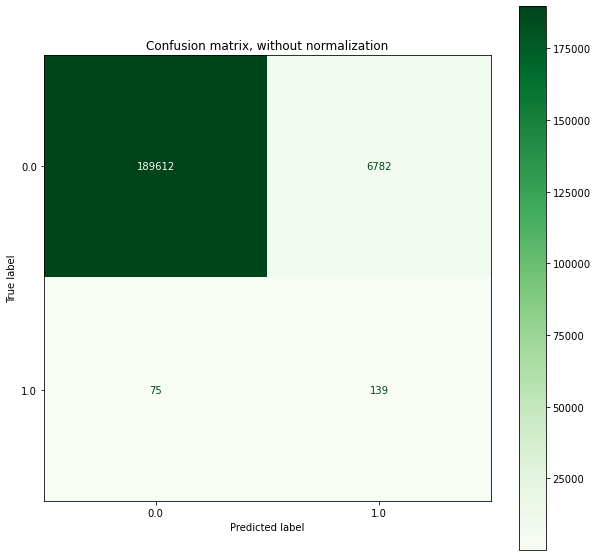

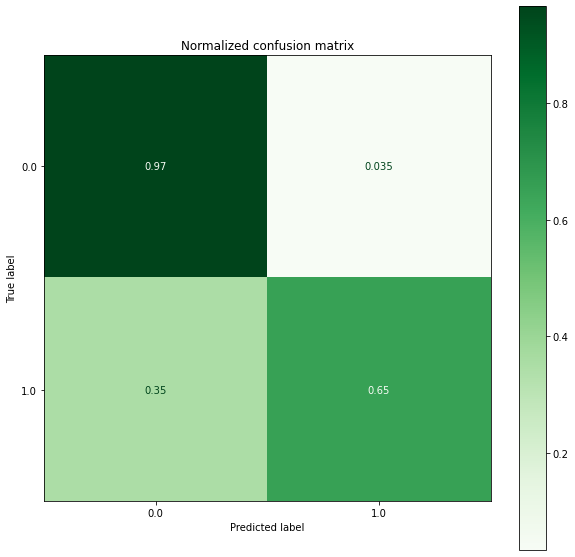

In [52]:
 titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
        fig, ax = plt.subplots(figsize=(10, 10))
        disp = ConfusionMatrixDisplay.from_predictions(yval, ypred,
                                                       cmap=plt.cm.Greens,
                                                       normalize=normalize,
                                                       ax=ax)
        ax.set_title(title)

**Conclusions**
- Using a model of SVM (Classification) is worse than using the Logistic Regressions in a matter of recall. The result of the score F2 is 51% wich means that the models is nearly randomly predicting the outputs.And the recall is only 65%, being the recall of the Logistic Regression Models 86%.This model is not good to identify the fraudulent transactions as the 35% of the times, the transactions that are fraudulent are not correctly identify.

Comparing to the base model this has a better output, but it is not the best model executed in this project.

### Random Forest

In [53]:
clf = Pipeline(steps=[
    ('preprocesador', preprocessor), 
    ('clasificador', RandomForestClassifier(random_state=0))])

In [54]:
clf.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['step', 'amount', 'connection_time', 'oldbalanceOrg', 'newbalanceOrig',
       'user_number', 'user_connections', 'security_alert', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'device', 'zone'], dtype='object'))])),
                ('clasificador', RandomForestClassifier(random_state=0))])

In [55]:
with open('../modelos/RandomForest.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [56]:
cargar_modelo('../modelos/RandomForest.pickle')

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['step', 'amount', 'connection_time', 'oldbalanceOrg', 'newbalanceOrig',
       'user_number', 'user_connections', 'security_alert', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'device', 'zone'], dtype='object'))])),
                ('clasificador', RandomForestClassifier(random_state=0))])

In [57]:
ypred = clf.predict(xval)
ypred_proba = clf.predict_proba(xval)
evaluate_model(yval,ypred,ypred_proba)

ROC-AUC score of the model: 0.992060947671565

F2 Score: 0.527682960337742

R2 Score: -43.927406370505054

Accuracy of the model: 0.9511515299479166

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97    196394
         1.0       0.02      0.94      0.04       214

    accuracy                           0.95    196608
   macro avg       0.51      0.95      0.51    196608
weighted avg       1.00      0.95      0.97    196608




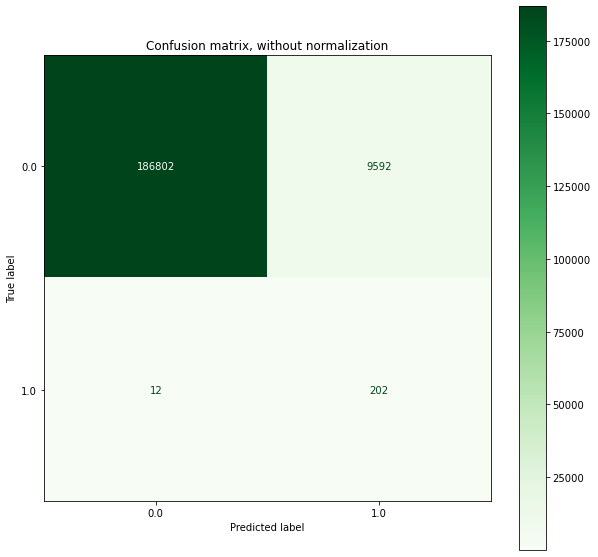

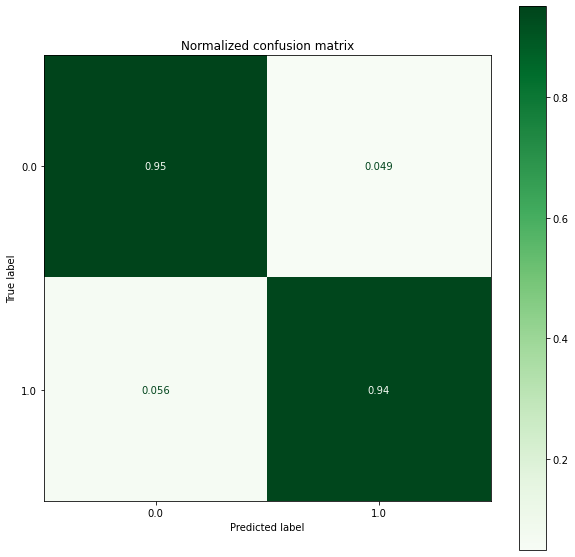

In [58]:
 titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
        fig, ax = plt.subplots(figsize=(10, 10))
        disp = ConfusionMatrixDisplay.from_predictions(yval, ypred,
                                                       cmap=plt.cm.Greens,
                                                       normalize=normalize,
                                                       ax=ax)
        ax.set_title(title)

**Conclusions**
- The model of Random Forest by far the best output the we have had during until this point in the project.In a matter of recall the model was able to detect 92% of the fraudulent transactions. This model has the best output comparing the others executed above.
- Regardless a good recall, the precision of this model is not good having an output of 2% of precision, which means that the model is declaring more fraudulent transactions that what really are.

### XGBoost

In [59]:
clf = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('clasificador', XGBClassifier(random_state=0))])

In [60]:
clf.fit(xtrain, ytrain)

[22:45:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['step', 'amount', 'connection_time', 'oldbalanceOrg', 'newbalanceOrig',
       'user_number', 'user_connections', 'security_alert', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')),
                                                 ('cat',
                                                  Pipe...
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [61]:
with open('../modelos/XGBoost.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [62]:
cargar_modelo('../modelos/XGBoost.pickle')

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['step', 'amount', 'connection_time', 'oldbalanceOrg', 'newbalanceOrig',
       'user_number', 'user_connections', 'security_alert', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')),
                                                 ('cat',
                                                  Pipe...
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [63]:
ypred = clf.predict(xval)
ypred_proba = clf.predict_proba(xval)
evaluate_model(yval,ypred,ypred_proba)

ROC-AUC score of the model: 0.9952772792514456

F2 Score: 0.5453799473924825

R2 Score: -34.365596851417976

Accuracy of the model: 0.9615478515625

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98    196394
         1.0       0.03      0.98      0.05       214

    accuracy                           0.96    196608
   macro avg       0.51      0.97      0.52    196608
weighted avg       1.00      0.96      0.98    196608




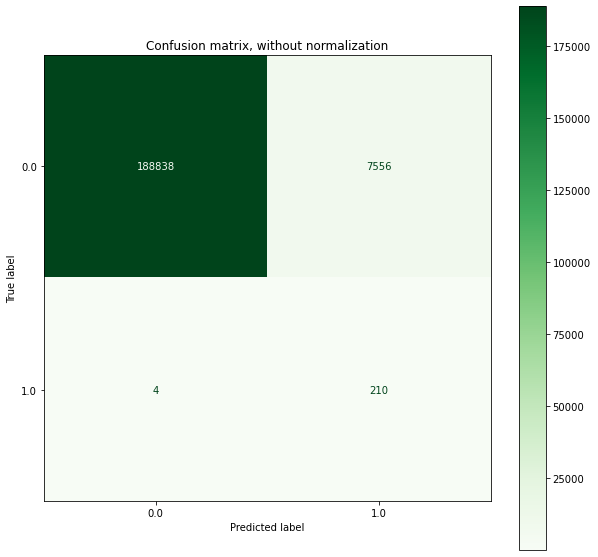

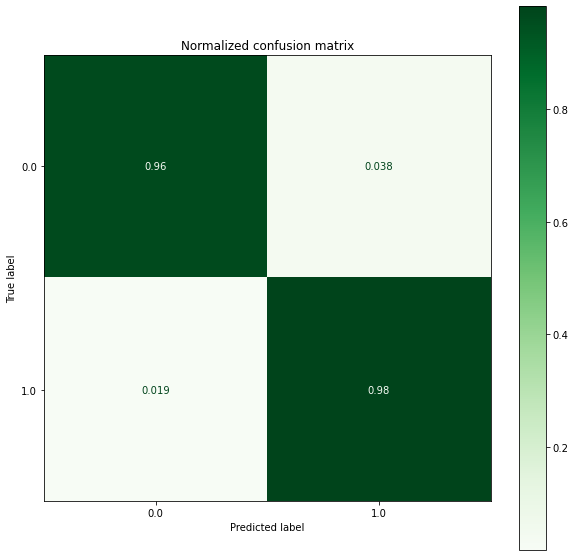

In [64]:
 titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
        fig, ax = plt.subplots(figsize=(10, 10))
        disp = ConfusionMatrixDisplay.from_predictions(yval, ypred,
                                                       cmap=plt.cm.Greens,
                                                       normalize=normalize,
                                                       ax=ax)
        ax.set_title(title)

**Conclusions**
- In XGBoost the recall of this model to capture fraudulent transactions is 96%. Which measn that the model is good predicting the fraudulent transactions.   
- Regardless a good recall, the precision of this model is not good having an output of 3% of precision, which means that the model is declaring more fraudulent transactions that what really are. This is a low precision number but is the best precision that we have seeing in the test.

### LightGBM

In [65]:
clf = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('clasificador', lgb.LGBMClassifier(random_state=0))])

In [66]:
clf.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['step', 'amount', 'connection_time', 'oldbalanceOrg', 'newbalanceOrig',
       'user_number', 'user_connections', 'security_alert', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'device', 'zone'], dtype='object'))])),
                ('clasificador', LGBMClassifier(random_state=0))])

In [67]:
with open('../modelos/LightGBM.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [68]:
cargar_modelo('../modelos/LightGBM.pickle')

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['step', 'amount', 'connection_time', 'oldbalanceOrg', 'newbalanceOrig',
       'user_number', 'user_connections', 'security_alert', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'device', 'zone'], dtype='object'))])),
                ('clasificador', LGBMClassifier(random_state=0))])

In [69]:
ypred = clf.predict(xval)
ypred_proba = clf.predict_proba(xval)
evaluate_model(yval,ypred,ypred_proba)

ROC-AUC score of the model: 0.9964648119615357

F2 Score: 0.546228854252912

R2 Score: -33.654542523188404

Accuracy of the model: 0.9623209635416666

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98    196394
         1.0       0.03      0.97      0.05       214

    accuracy                           0.96    196608
   macro avg       0.51      0.97      0.52    196608
weighted avg       1.00      0.96      0.98    196608




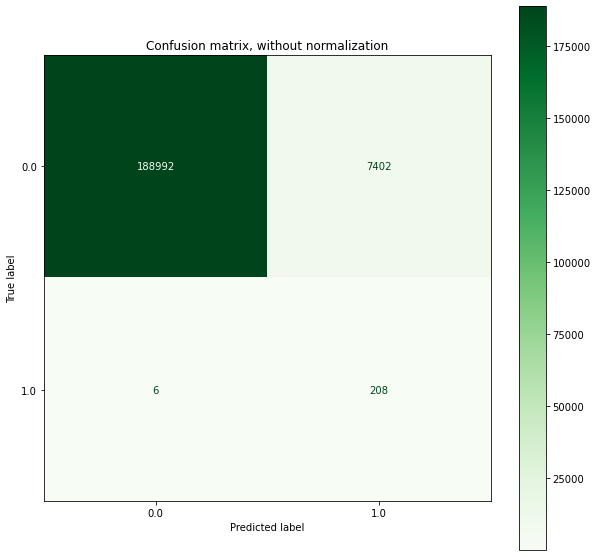

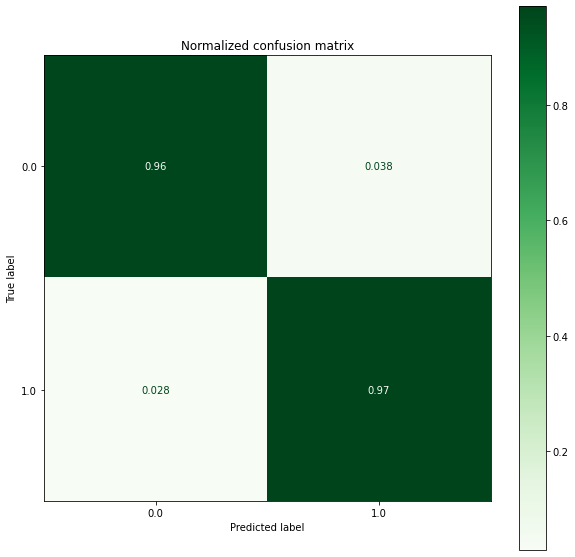

In [70]:
 titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
        fig, ax = plt.subplots(figsize=(10, 10))
        disp = ConfusionMatrixDisplay.from_predictions(yval, ypred,
                                                       cmap=plt.cm.Greens,
                                                       normalize=normalize,
                                                       ax=ax)
        ax.set_title(title)

**Conclusions**
- In LightGBM the recall of this model to capture fraudulent transactions is 97%. Which measn that the model is good predicting the fraudulent transactions.   
- As the same as the other cases, regardless a good recall the precision of this model is not good having an output of 3% of precision, which means that the model is declaring more fraudulent transactions that what really are.

### AdaBoost

In [71]:
clf = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('clasificador', AdaBoostClassifier(random_state=0))])

In [72]:
clf.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['step', 'amount', 'connection_time', 'oldbalanceOrg', 'newbalanceOrig',
       'user_number', 'user_connections', 'security_alert', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'device', 'zone'], dtype='object'))])),
                ('clasificador', AdaBoostClassifier(random_state=0))])

In [73]:
with open('../modelos/AdaBoost.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [74]:
cargar_modelo('../modelos/AdaBoost.pickle')

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['step', 'amount', 'connection_time', 'oldbalanceOrg', 'newbalanceOrig',
       'user_number', 'user_connections', 'security_alert', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'device', 'zone'], dtype='object'))])),
                ('clasificador', AdaBoostClassifier(random_state=0))])

In [75]:
ypred = clf.predict(xval)
ypred_proba = clf.predict_proba(xval)
evaluate_model(yval,ypred,ypred_proba)

ROC-AUC score of the model: 0.9838288905032503

F2 Score: 0.4982455766923919

R2 Score: -72.28537569766058

Accuracy of the model: 0.920318603515625

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96    196394
         1.0       0.01      0.96      0.03       214

    accuracy                           0.92    196608
   macro avg       0.51      0.94      0.49    196608
weighted avg       1.00      0.92      0.96    196608




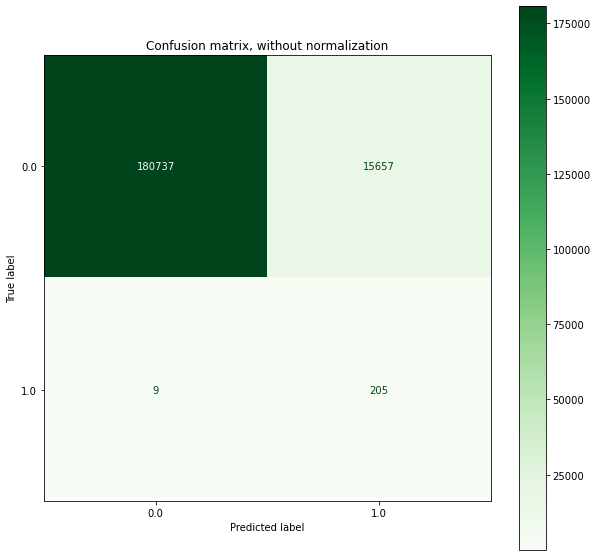

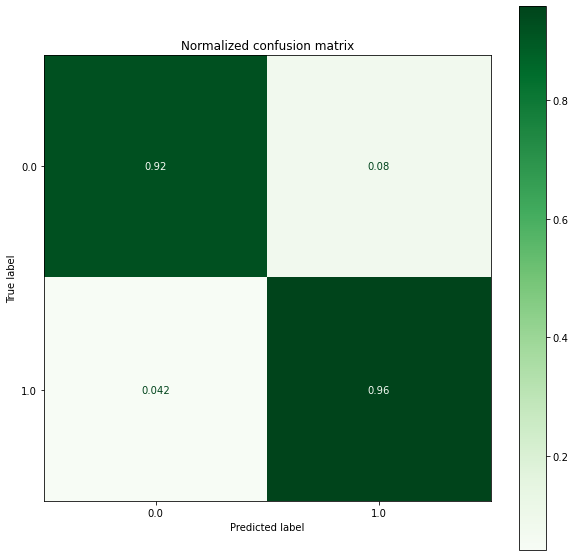

In [76]:
 titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
        fig, ax = plt.subplots(figsize=(10, 10))
        disp = ConfusionMatrixDisplay.from_predictions(yval, ypred,
                                                       cmap=plt.cm.Greens,
                                                       normalize=normalize,
                                                       ax=ax)
        ax.set_title(title)

**Conclusions**
- In AdaBoost the recall of this model to capture fraudulent transactions is 90%.  This means that the model could predict the 90% of the fraudulent transactions, as fraudulent. Only 28 transactions that were fraud were mistakenly classify as not being fraudulent.
- For this model the precision is really low, with 1% of all the transactions that were fraudulent being correctly class as fraudulent. This models is predicting more fraudulet transactions than what there are

# Seleccion del modelo(s) a optimizar

Una vez realizada la comprobacion de diferentes modelos para nuestro dataset, vamos a observar cada uno de ellos de manera individual para posteriormente seleccionar uno y proceder a su optimización.

In [77]:
xtrain.columns

Index(['step', 'type', 'amount', 'gender', 'device', 'connection_time',
       'oldbalanceOrg', 'newbalanceOrig', 'zone', 'user_number',
       'user_connections', 'security_alert', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')

In [78]:
models = {'Model': ['Base Model', 'Ridge', 'Lasso','GLM', 'SVM', 'Random Forest','XGBoost','LightGBM', 'AdaBoost'],

                'ROC-AUC': ['0.500', '0.95', '0.94', '-', '0.83', '0.98', '0.99', '0.99', '0.97'],

                'F2 Score': ['0.49', '0.52', '0.52', '-', '0.51', '0.52', '0.55', '0.56', '0.5'],

                'R2 Score': ['-1.001', '-43.08', '-39.51', '-', '-44.25', '-42.25', '-29.7', '-26.55', '-63.32'],

                'Accuracy':['0.99', '0.95', '0.95', '-', '0.95', '0.95', '0.97', '0.97', '0.93'],
                
                'Recall':['0', '0.85', '0.81', '-', '0.65', '0.92', '0.96', '0.97', '0.9'],
          
                'Precision':['0', '0.02', '0.02', '-', '0.01', '0.02', '0.03', '0.03', '0.01']
         
         
         }

table = pd.DataFrame(models, columns=['Model', 'ROC-AUC', 'F2 Score',
                                                    'R2 Score', 'Accuracy', 'Recall', 'Precision'])

In [79]:
table

,Model,ROC-AUC,F2 Score,R2 Score,Accuracy,Recall,Precision
0,Base Model,0.500,0.49,-1.001,0.99,0,0
1,Ridge,0.95,0.52,-43.08,0.95,0.85,0.02
2,Lasso,0.94,0.52,-39.51,0.95,0.81,0.02
3,GLM,-,-,-,-,-,-
4,SVM,0.83,0.51,-44.25,0.95,0.65,0.01
5,Random Forest,0.98,0.52,-42.25,0.95,0.92,0.02
6,XGBoost,0.99,0.55,-29.7,0.97,0.96,0.03
7,LightGBM,0.99,0.56,-26.55,0.97,0.97,0.03
8,AdaBoost,0.97,0.5,-63.32,0.93,0.9,0.01


As mention in the objective of this project, we are going to be focus on the model with the best recall output or in other words the model with the best ability of correctly classify the fraudulent transaction as fraudulent. Base on the outputs of the table above the model with the best recall was the LightGBM, with 97% of recall and 3% of precision, followed by the XGBoost. All the models that we run had a low precision because of the model is identifying more transactions as fraudulent than the real fraudulent transactions. this low precision can be as a result of the data decreasing that happened to balance the data and be able to run the different models.

We are going to take the **LightGBM** model and adjust the hyperparameters trying to obtain a best results on the recall and precision of the model